<a href="https://colab.research.google.com/github/manumoreira/survedaUtils/blob/main/SurvedaDelays%26Prios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict
from google.colab import files

## This notebook calculates delays and priorities in a Surveda survey

Surveys have a defined retry window, this code aims to check if the contact attempts match those settings.

The **Channel broker** handles the contact attempts that are sent to the channels, it has 2 queues High (1) and Normal (0) tha script check if the contact attempts were sent according to these priorities

In [6]:
#Load data

interaction_df = pd.read_csv('https://surveda-stg.instedd.org/link/8ba3cf8bfec35e054d0654ea31ff8231')
results_df = pd.read_csv('https://surveda-stg.instedd.org/link/570eb9e34c41b9d2475b42e5dec6eaf1')

#print(interaction_df.head())
#print(results_df.head())

<ipython-input-6-519b09cbe775>:4: DtypeWarning: Columns (3,7,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df = pd.read_csv('https://surveda-stg.instedd.org/link/570eb9e34c41b9d2475b42e5dec6eaf1')


In [8]:
# Filter data

filter_out = ['Enqueueing call', 'Timeout', 'User hangup']
#
contact_inter_df = interaction_df.loc[(interaction_df['Action Type'] == 'Contact attempt') & (~interaction_df['Action Data'].isin(filter_out))]
contact_inter_df = contact_inter_df.sort_values(['Respondent ID','ID'])

#print(contact_inter_df)
print(contact_inter_df.head())

         ID  Respondent ID Mode        Channel Disposition      Action Type  \
1   4365541  r0001862425da  IVR  twiliosim-stg      Queued  Contact attempt   
2   4406604  r0001862425da  IVR  twiliosim-stg      Queued  Contact attempt   
19  4423565  r00048f04776d  IVR  twiliosim-stg      Queued  Contact attempt   
20  4461522  r00048f04776d  IVR  twiliosim-stg      Queued  Contact attempt   
23  4445341  r00054bf9ae6c  IVR  twiliosim-stg      Queued  Contact attempt   

   Action Data                  Timestamp  
1    no-answer  2024-08-27 15:29:56 GMT-3  
2       Answer  2024-08-28 15:34:08 GMT-3  
19   no-answer  2024-08-29 08:26:45 GMT-3  
20   no-answer  2024-08-30 10:16:02 GMT-3  
23   no-answer  2024-08-29 14:42:23 GMT-3  


In [9]:
# Calculate retry time

def calculate_retry_time (input_date, delay_hours: int, start_window: int, end_window: int):
  start_date = pd.to_datetime(input_date).tz_localize(None)
  target_datetime = start_date + pd.DateOffset(hours=delay_hours)
  if start_window <= target_datetime.hour < end_window:
        valid_target_datetime = target_datetime
  else:
    # Calculate valid_target_datetime for the case when it's outside the time window
    if target_datetime.hour < start_window:
        valid_target_datetime = pd.Timestamp(
            year=target_datetime.year,
            month=target_datetime.month,
            day=target_datetime.day,
            hour=start_window
        )
    else:
        valid_target_datetime = pd.Timestamp(
            year=target_datetime.year,
            month=target_datetime.month,
            day=target_datetime.day,
            hour=start_window
        ) + pd.DateOffset(days=1)

  return valid_target_datetime

# Example usage
input_date = '2024-08-30 18:51:20 GMT-3'  # Example start date
delay_hours = 26
start_window = 8
end_window = 20

result = calculate_retry_time(input_date, delay_hours, start_window, end_window)
print(result)

2024-09-01 08:00:00


# Calculate retry time delays

This code crawls the interactions file, seareching for the contact attempt registries and compares its timestamo with the estimated (using calculate_retry_time)

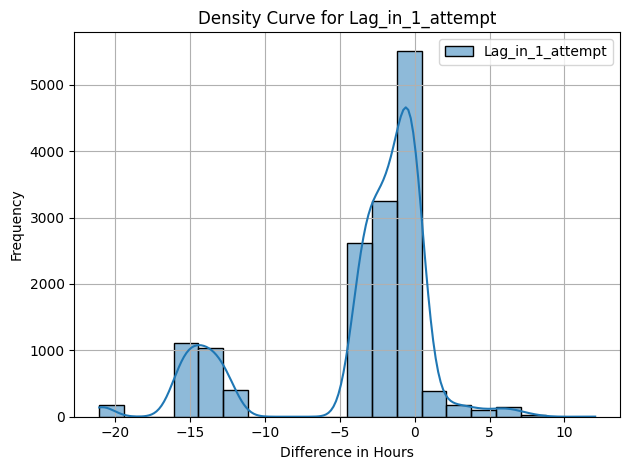

In [28]:
# Diff between estimates and real call time


def retry_accuracy(data, delay_hours: int, start_window: int, end_window: int, retries: int):

    result_list = []

    data['Timestamp'] = pd.to_datetime(data['Timestamp']).dt.tz_localize(None)

    # Group by 'Respondent ID'
    respondents_id = data.groupby('Respondent ID')

    for respondent_id, group in respondents_id:
        occurrences = len(group)

        if occurrences > 1:
            timestamps = pd.to_datetime(group['Timestamp'])
            initial_time = calculate_retry_time(timestamps.iloc[0], delay_hours, start_window, end_window)

            differences = []
            for i in range(1, min(occurrences, retries + 1)):
              diff = (timestamps.iloc[i] - initial_time)
              differences.append(diff.total_seconds()/3600)
              initial_time = calculate_retry_time(timestamps.iloc[i], delay_hours, start_window, end_window)

            result_list.append([respondent_id] + differences)

    # Creating the final DataFrame with dynamically added columns
    columns = ['Respondent ID'] + [f'Lag_in_{i+1}_attempt' for i in range(retries)]
    contact_lag_df = pd.DataFrame(result_list, columns=columns)

    return contact_lag_df

retries = 1
delay_hours = 26
start_window = 8
end_window = 20

contact_lag_df = retry_accuracy(contact_inter_df, delay_hours, start_window, end_window, retries)

# Create csv file to export
contact_lag_df.to_csv('contactLag.csv', index=False)
files.download('contactLag.csv')

# Plot differences
column_names = [f'Lag_in_{i+1}_attempt' for i in range(retries)]
plt.figure(figsize=(5 * retries, 5))

for i, col in enumerate(column_names):
    if col in contact_lag_df.columns:
        plt.subplot(1, retries, i+1)
        sns.histplot(contact_lag_df[col].dropna(), bins=20, kde=True, label=col)
        plt.title(f'Density Curve for {col}')
        plt.xlabel('Difference in Hours')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Verify Channel Broker priorities

# Order Respondents IDs by ID (it actually orders by Contact time, we do not use Timestamp because it doesn't consider miliseconds)
# Once we have an ordered list of Respondents IDs by its first contact attemmpt we assign them to a group priroty 1+number of day and then iterate the list
#